In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GPT2/GPT2_After_RLHF.csv')

In [25]:
df

,Unnamed: 0,Question,Gen_Answer,Gen_Grade,Gen_Reward,RL_Answer,RL_Grade,RL_Reward
0,0,You participated in a competition and won the ...,"Dear Helen Ryan, I am writing to you to tell ...",NaN,NaN,"Dear Helen Ryan, I am writing to you to tell ...",NaN,NaN
1,1,Your class is going to make a short video on d...,The video should cover the lessons in the scho...,NaN,NaN,The video should cover the main subjects of da...,NaN,NaN
2,2,"Write a composition giving your opinions on ""S...",Shopping is always unpleasant I think that sh...,NaN,NaN,Shopping is sometimes not enjoyable I have be...,NaN,NaN
3,3,Last month you helped organizing a pop concert...,"Dear Kim, I'm writing to you because I was ve...",NaN,NaN,"Dear Kim, I'm writing to you because I was re...",NaN,NaN
4,4,Your English class is going to spend three day...,"Dear Mr Robertson, I am writing to you to ask...",NaN,NaN,"Dear Mr Robertson, I am writing to you to ask...",NaN,NaN
5,5,"Write a composition giving your opinions on ""F...",I think that famous people deserve a private ...,NaN,NaN,I think that famous people should have their o...,NaN,NaN
6,6,"write an article on, ""The Home of the Future: ...",The Home of the Future In what ways do...,NaN,NaN,"The Home Of The Future In the past, people li...",NaN,NaN
7,7,Write a story for the college magazine beginni...,"It was risky, I know, because I was a studen...",NaN,NaN,"It was risky, I know, and I was scared, too. B...",NaN,NaN
8,8,You are helping to organise an international s...,"Dear Mrs Smith, I am writing to you to tell y...",NaN,NaN,"Dear Mrs Smith, I am writing to you to tell y...",NaN,NaN
9,9,Write a report for the group leader of a group...,"I would like to recommend a building to you,...",NaN,NaN,I am writing to you to give you some advice on...,NaN,NaN


**REWARD**

In [26]:
!pip install transformers -q
!pip install datasets==2.16.1 -q
from datasets import load_dataset

In [27]:
import numpy as np
from transformers import Pipeline


def softmax(outputs):
    maxes = np.max(outputs, axis=-1, keepdims=True)
    shifted_exp = np.exp(outputs - maxes)
    return shifted_exp / shifted_exp.sum(axis=-1, keepdims=True)


class PairClassificationPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        if "second_text" in kwargs:
            preprocess_kwargs["second_text"] = kwargs["second_text"]
        return preprocess_kwargs, {}, {}

    def preprocess(self, text, second_text=None):
        return self.tokenizer(text, text_pair=second_text, return_tensors=self.framework)

    def _forward(self, model_inputs):
        return self.model(**model_inputs)

    def postprocess(self, model_outputs):
        logits = model_outputs.logits[0].numpy()
        probabilities = softmax(logits)

        best_class = np.argmax(probabilities)
        label = self.model.config.id2label[best_class]
        score = probabilities[best_class].item()
        logits = logits.tolist()
        return {"label": label, "score": score, "logits": logits}




from transformers.pipelines import PIPELINE_REGISTRY
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification

PIPELINE_REGISTRY.register_pipeline(
    "pair-classification",
    pipeline_class=PairClassificationPipeline,
    pt_model=AutoModelForSequenceClassification,
    tf_model=TFAutoModelForSequenceClassification,
)



from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Specify the model and tokenizer names
model_name = "RajuEEE/RewardModel_RobertaBase"
tokenizer_name = "RajuEEE/RewardModel_RobertaBase"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Instantiate the PairClassificationPipeline
qa_pipe = PairClassificationPipeline(model=model, tokenizer=tokenizer)

pair-classification is already registered. Overwriting pipeline for task pair-classification...


tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/836 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [28]:
out=qa_pipe(df.iloc[0]['Question'],second_text=df.iloc[0]['Gen_Answer'] )
df.at[0, 'Gen_Grade']=out['label']
df.at[0, 'Gen_Reward']=out['logits'][1]

In [29]:
df

,Unnamed: 0,Question,Gen_Answer,Gen_Grade,Gen_Reward,RL_Answer,RL_Grade,RL_Reward
0,0,You participated in a competition and won the ...,"Dear Helen Ryan, I am writing to you to tell ...",Good,2.096532,"Dear Helen Ryan, I am writing to you to tell ...",NaN,NaN
1,1,Your class is going to make a short video on d...,The video should cover the lessons in the scho...,NaN,NaN,The video should cover the main subjects of da...,NaN,NaN
2,2,"Write a composition giving your opinions on ""S...",Shopping is always unpleasant I think that sh...,NaN,NaN,Shopping is sometimes not enjoyable I have be...,NaN,NaN
3,3,Last month you helped organizing a pop concert...,"Dear Kim, I'm writing to you because I was ve...",NaN,NaN,"Dear Kim, I'm writing to you because I was re...",NaN,NaN
4,4,Your English class is going to spend three day...,"Dear Mr Robertson, I am writing to you to ask...",NaN,NaN,"Dear Mr Robertson, I am writing to you to ask...",NaN,NaN
5,5,"Write a composition giving your opinions on ""F...",I think that famous people deserve a private ...,NaN,NaN,I think that famous people should have their o...,NaN,NaN
6,6,"write an article on, ""The Home of the Future: ...",The Home of the Future In what ways do...,NaN,NaN,"The Home Of The Future In the past, people li...",NaN,NaN
7,7,Write a story for the college magazine beginni...,"It was risky, I know, because I was a studen...",NaN,NaN,"It was risky, I know, and I was scared, too. B...",NaN,NaN
8,8,You are helping to organise an international s...,"Dear Mrs Smith, I am writing to you to tell y...",NaN,NaN,"Dear Mrs Smith, I am writing to you to tell y...",NaN,NaN
9,9,Write a report for the group leader of a group...,"I would like to recommend a building to you,...",NaN,NaN,I am writing to you to give you some advice on...,NaN,NaN


In [30]:
out['logits'][1]

2.096532106399536

In [31]:
for i in range(len(df)):
  print(i)
  text1=df.iloc[i]['Question']
  text2=df.iloc[i]['Gen_Answer']
  text3=df.iloc[i]['Gen_Answer']

  out=qa_pipe(df.iloc[i]['Question'],second_text=df.iloc[i]['Gen_Answer'] )
  df.at[i, 'Gen_Grade']=out['label']
  df.at[i, 'Gen_Reward']=out['logits'][1]

  out=qa_pipe(df.iloc[i]['Question'],second_text=df.iloc[i]['RL_Answer'] )
  df.at[i, 'RL_Grade']=out['label']
  df.at[i, 'RL_Reward']=out['logits'][1]




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


# Performance on Training Data

In [32]:
df_train=df[0:26]

Statistical measures for RL_Reward(Training Data):
Mean: 2.5946730283590465
Variance: 0.016181014210479728
Median: 2.6141791343688965


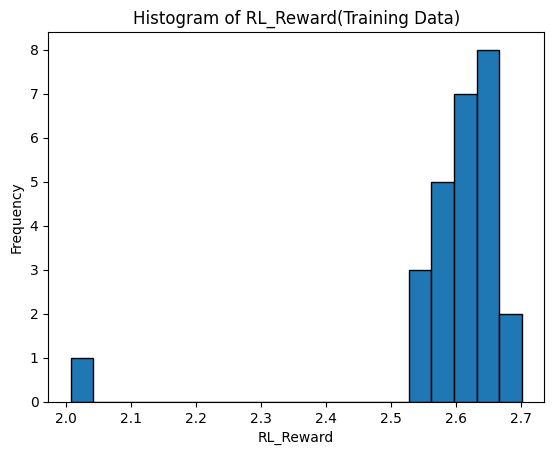

Number of 'Good' in RL_Answer column: 26
Percentage of 'Good' in RL_Answer column: 100.0


In [33]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Example DataFrame creation:
# df = pd.DataFrame({'RL_Reward': [10, 15, 20, 25, 30],
#                    'RL_Answer': ['Good', 'Bad', 'Good', 'Bad', 'Good']})

# Display various statistical measures for RL_Reward
print("Statistical measures for RL_Reward(Training Data):")
print("Mean:", df_train['RL_Reward'].mean())
print("Variance:", df_train['RL_Reward'].var())
print("Median:", df_train['RL_Reward'].median())

# Draw histogram for RL_Reward
plt.hist(df_train['RL_Reward'], bins=20, edgecolor='black')
plt.title('Histogram of RL_Reward(Training Data)')
plt.xlabel('RL_Reward')
plt.ylabel('Frequency')
plt.show()

# Find the number of "Good" in RL_Answer column
good_count = df_train['RL_Grade'].value_counts().get('Good', 0)
print("Number of 'Good' in RL_Answer column:", good_count)

total_rows = len(df_train)
percentage_good = (df_train['RL_Grade'].value_counts().get('Good', 0) / total_rows) * 100
print("Percentage of 'Good' in RL_Answer column:", percentage_good)


Statistical measures for Gen_Reward(Training Data):
Mean: 0.3420366163437183
Variance: 2.7488562726157193
Median: 0.4633893221616745


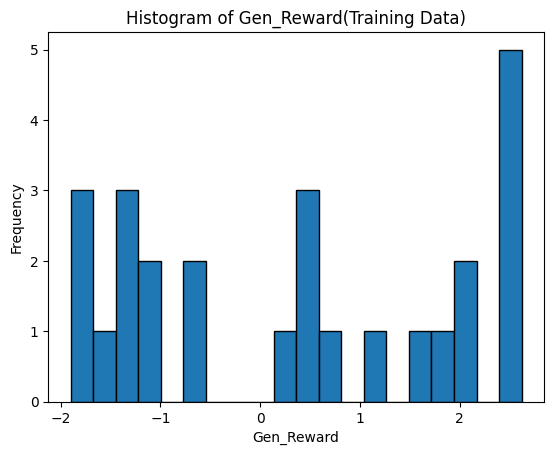

Number of 'Good' in Gen_Grade column: 15
Percentage of 'Good' in Gen_Grade column: 57.692307692307686


In [34]:
# Display various statistical measures for Gen_Reward
print("Statistical measures for Gen_Reward(Training Data):")
print("Mean:", df_train['Gen_Reward'].mean())
print("Variance:", df_train['Gen_Reward'].var())
print("Median:", df_train['Gen_Reward'].median())

# Draw histogram for RL_Reward
plt.hist(df_train['Gen_Reward'], bins=20, edgecolor='black')
plt.title('Histogram of Gen_Reward(Training Data)')
plt.xlabel('Gen_Reward')
plt.ylabel('Frequency')
plt.show()

# Find the number of "Good" in Gen_Grade column
good_count = df_train['Gen_Grade'].value_counts().get('Good', 0)
print("Number of 'Good' in Gen_Grade column:", good_count)

total_rows = len(df_train)
percentage_good = (df_train['Gen_Grade'].value_counts().get('Good', 0) / total_rows) * 100
print("Percentage of 'Good' in Gen_Grade column:", percentage_good)

In [35]:
print("Total Rows for Training Data:", len(df_train))
improvement=len(df_train[df_train['RL_Reward'] > df_train['Gen_Reward']])
print("RL Improves Reward for:", improvement,"Rows")
print("Percentage of Cases RL Improves Reward:",(improvement/len(df_train))*100,"%");

Total Rows for Training Data: 26
RL Improves Reward for: 25 Rows
Percentage of Cases RL Improves Reward: 96.15384615384616 %


# Performance on Evaluation Data

In [36]:
df_eval=df[26:]

Statistical measures for RL_Reward(Evaluation Data):
Mean: 2.638237774372101
Variance: 0.0007154565884622922
Median: 2.647055745124817


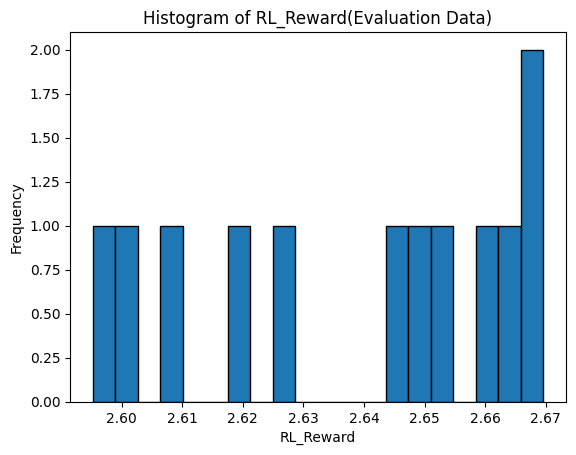

Number of 'Good' in RL_Answer column: 12
Percentage of 'Good' in RL_Answer column: 100.0


In [37]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Example DataFrame creation:
# df = pd.DataFrame({'RL_Reward': [10, 15, 20, 25, 30],
#                    'RL_Answer': ['Good', 'Bad', 'Good', 'Bad', 'Good']})

# Display various statistical measures for RL_Reward
print("Statistical measures for RL_Reward(Evaluation Data):")
print("Mean:", df_eval['RL_Reward'].mean())
print("Variance:", df_eval['RL_Reward'].var())
print("Median:", df_eval['RL_Reward'].median())

# Draw histogram for RL_Reward
plt.hist(df_eval['RL_Reward'], bins=20, edgecolor='black')
plt.title('Histogram of RL_Reward(Evaluation Data)')
plt.xlabel('RL_Reward')
plt.ylabel('Frequency')
plt.show()

# Find the number of "Good" in RL_Answer column
good_count = df_eval['RL_Grade'].value_counts().get('Good', 0)
print("Number of 'Good' in RL_Answer column:", good_count)

total_rows = len(df_eval)
percentage_good = (df_eval['RL_Grade'].value_counts().get('Good', 0) / total_rows) * 100
print("Percentage of 'Good' in RL_Answer column:", percentage_good)


Statistical measures for Gen_Reward(Evaluation Data):
Mean: 0.550717880949378
Variance: 2.196339870755388
Median: 0.49634793773293495


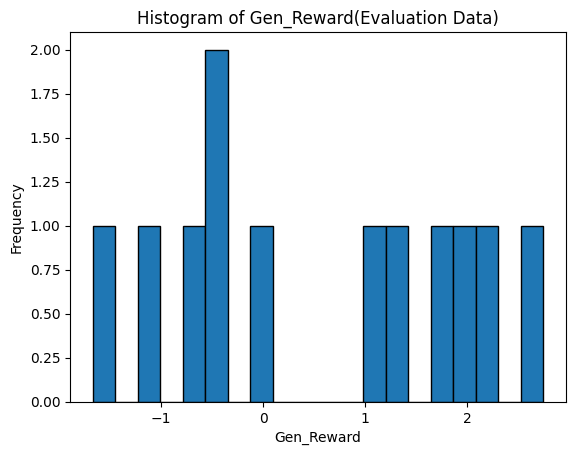

Number of 'Good' in Gen_Grade column: 6
Percentage of 'Good' in Gen_Grade column: 50.0


In [38]:
# Display various statistical measures for Gen_Reward
print("Statistical measures for Gen_Reward(Evaluation Data):")
print("Mean:", df_eval['Gen_Reward'].mean())
print("Variance:", df_eval['Gen_Reward'].var())
print("Median:", df_eval['Gen_Reward'].median())

# Draw histogram for RL_Reward
plt.hist(df_eval['Gen_Reward'], bins=20, edgecolor='black')
plt.title('Histogram of Gen_Reward(Evaluation Data)')
plt.xlabel('Gen_Reward')
plt.ylabel('Frequency')
plt.show()

# Find the number of "Good" in Gen_Grade column
good_count = df_eval['Gen_Grade'].value_counts().get('Good', 0)
print("Number of 'Good' in Gen_Grade column:", good_count)

total_rows = len(df_eval)
percentage_good = (df_eval['Gen_Grade'].value_counts().get('Good', 0) / total_rows) * 100
print("Percentage of 'Good' in Gen_Grade column:", percentage_good)

In [39]:
print("Total Rows for Training Data:", len(df_eval))
improvement=len(df_eval[df_eval['RL_Reward'] > df_eval['Gen_Reward']])
print("RL Improves Reward for:", improvement,"Rows")
print("Percentage of Cases RL Improves Reward:",(improvement/len(df_eval))*100,"%");

Total Rows for Training Data: 12
RL Improves Reward for: 11 Rows
Percentage of Cases RL Improves Reward: 91.66666666666666 %


**Visual Evaluation**

In [44]:
for i in range(0,25,10):
  display("Question:",df_train.iloc[i]["Question"])
  print("FineTunedModel:")
  display(df_train.iloc[i]['Gen_Answer'])
  print("After RLHF:");
  display(df_train.iloc[i]['RL_Answer'])
  print("\n\n")

'Question:'

'You participated in a competition and won the first prize. The Organizer had written you a letter congratulating you. Now, Write a reply letter of between 120 to 180 words.'

FineTunedModel:


'Dear Helen Ryan,  I am writing to you to tell you that I have won first place in your competition. I would like to travel in July because I want to go to the USA in June. In addition, I prefer to stay in log cabins because they are more comfortable. Also, it is very important for me to have a   good  internet connection. Finally, the activities I  would choose are surfing and photography.  Yours sincerely  Karina'

After RLHF:


"Dear Helen Ryan,  I am writing to you to tell you that I have won first place in your competition. I would like to travel in July because I want to go to the USA in August. My favourite activities are surfing and camping. In addition, I like the idea of going to a campground because it is a great way to relax and have fun. Also, it's a good way for me to learn about the different kinds of camping and how to use them. Finally, my favourite activity is surfing. It is very fun and I can do it whenever I feel like it. If you have any questions, please ask them to me. Thank you very much for your kind invitation.   Yours sincerely  A.B.S.L.A.P.E.R.I.N.O.U.M.T.H.Y.V.C.K.D.W.F.G.Q.J.Z.X. P. S. You can find me on Facebook at: https://www.facebook.com/ABSOLUTEL"

'Question:'

'Write an article for an international magazine on a great scientific invention, explaining why you think it is important and saying how it has affected your own life. '

FineTunedModel:


"I am writing this article to explain why I think   the invention of the  digital camera is so important. I have been using a digital  camera for a long time and I can't imagine  living without it. It is a very useful tool for me. The digital cameras are very good at taking pictures and they are also very  good for taking  pictures of people. They are  very easy to use and you can take pictures  of  people  without any problems. You can  take a picture of a person and  send it to a friend or  to your boss. If you want to take  a photo of your friend, you just have to  click on the picture and it will be  sent to him. This is very convenient and very important for my life.  I hope you will find this interesting"

After RLHF:


"I'm not sure if I can answer this question, but I think that the invention of the bicycle is one of my favourite inventions. I've been riding a bicycle for a long time now, and I have to say that it's a very comfortable and convenient way to get around. It's also very convenient for me to take my bike with me wherever I go. The bicycle has changed my life in a lot of ways. For example, I don't have any problems with my back, which is a problem that I had before. Also, it makes me feel more confident in my own skin. And I also have a better sense of direction. In addition, the bike is very useful for my job as a teacher. When I teach, my students are always very interested in the mechanics of bicycles. They are very curious about the things that are inside the frame. So, when I am teaching, they are interested to know more about it. But, as I said, this is just one example of how the bicycles have changed the lives of many people. Another example is the fact that bicycles are a good wa

'Question:'

' Write a letter,of between 120 and 180 words  to the organizer,Jane Clark, on how annual international arts festival can be made better. .'

FineTunedModel:


'Dear Ms Clark  I am writing to you to complain about the annual International Arts Festival. I would like to thank you for organising such an event. However, I think that the festival is not very good. First of all, the weather is very bad. The festival starts at 19:00 and ends at 20:30. It is a very long festival. There are only two stages. In addition, there are no   concerts. The only thing that I like about this festival are the  arts. But I have to say that there is no free entry. You can only buy tickets for the free concerts. Also, you should have more  free  time for people who are not able to attend the concerts because of work. Finally, it is difficult to find the best places to eat.  Yours sincerely'

After RLHF:


'Dear Jane Clark  I am writing to you to ask for your help in making the International Arts Festival better for the people who attend it. I have been to many festivals and I can tell you that the festival is not always the best place to go to. The festival has a lot of problems, but I think that it is the only place where you can see the latest art and music. It is a great place for people to see new artists and new music, and it has the most beautiful art galleries. But the problem is that there are not enough places to buy tickets. There are only two places where people can buy a ticket. One is at the entrance of the main hall, where there is an entrance ticket for free. Another place is in the "arts" section, which is where the artists are. This is why I would like to suggest that you should have a "art" area in every festival. You should be able to find the artist\'s name and the name of their work. If you have any other suggestions, please let me know.   Yours sincerely  J.M.C. P.

In [43]:
for i in range(0,11,5):
  display("Question:",df_eval.iloc[i]["Question"])
  print("FineTunedModel:")
  display(df_eval.iloc[i]['Gen_Answer'])
  print("After RLHF:");
  display(df_eval.iloc[i]['RL_Answer'])
  print("\n\n")

'Question:'

'You have been asked to write an article for your school magazine with the title: My favourite season of the year. Describe your favourite season and explain why it is so special for you. Write your article'

FineTunedModel:


"I have to say that I am very happy with my favourite seasons. I think that it's the best season for me. It is the season when I can go to the beach and have fun. The weather is always nice and the   weather  is  always  sunny. I like to go swimming in the sea and I love to play  tennis. In the summer I go  to  the mountains and play tennis there.  I  love  playing tennis  in  my  favourite  season"

After RLHF:


"Summer is my favourite time of year, because it's the time when I can spend the most time with my family and friends. I love the weather, the sun, and the music. It's a great time to be outside, to play with friends, or just to relax. The weather is always beautiful, but it can be very hot and humid. In the summer, I like to go to the beach, which is a very relaxing activity. There are many different kinds of sand, so I have to choose the one that suits me best. If I'm not too tired, it doesn't matter if I go swimming or playing tennis. My family is very happy when they see me playing with them. They are always happy to see their children playing together. When I play tennis, my father is the coach. He is really good at tennis and he is also very good with his hands. We play together every day, even if we don't play as often as we used to. Sometimes, we play for hours, sometimes we just play a few minutes. But we always play, n"

'Question:'

'The school where you learn English has decided to buy some videos in English. Write a report suggesting what kinds of videos the school should buy. In your report, you should also explain why students at the school will enjoy these videos. Write your report'

FineTunedModel:


'I am writing to you to ask you  to   give us some information about the  school  that  we are going to attend. First of all, the video  is  very good and  interesting. The  teacher ,  who is a very nice person,  has  been  teaching English for a long time. She is very  good at  explaining the subject and she is also very patient. The other thing is that the students are very interested in  the videos. They are interested  in the different kinds and the kind of  activities that they can do. I think that it is the best choice for the children.  Yours faithfully'

After RLHF:


"The school has bought some English videos for the students. The students are very excited about the new videos and they are asking for more. I think that the videos are good for them. They are interesting and interesting to watch. It is a good idea to have a lot of fun with the video. You can do a dance, a song, or a funny story. If you want to do something, just do it. There are some things that you can't do in the movies. For example, if you are a boy, it is not possible to play football. But if it's a girl, she can play soccer. So, the best thing is to enjoy the fun."

'Question:'

"You have decided to enter a short story competition in an international magazine. The competition rules say that the story must begin with the following words: It was three o'clock in the morning when the phone rang. Write your story."

FineTunedModel:


'I was in a hurry and I had to get to the office. I went to my room and closed the door. Then I heard a voice. "Hello, I\'m sorry to disturb you, but I have to tell you something. You have won the competition and you have been chosen to write a story for the next issue. It is about a young man who is going to a party and he has to do something very important. He has a problem with his  girlfriend and she is not happy with him. She is a very good singer and  she has been singing for a long time. But she doesn\'t like  singing   and is always talking about  her  boyfriend. She has told him that she will not be able to sing with her boyfriend. So he is very upset and wants to go to her house.  I think that you will find it very interesting  Yours sincerely'

After RLHF:


'I was in a hurry and I had to get to the office. I got there and the receptionist was very nice. She asked me if I wanted to come in and see the latest issue. "Yes, I\'m very interested in this story," I said. Then she asked if there was anything else I needed. So I told her about my friend\'s new job. He was a very good student and he was going to be a doctor. But he had a problem. His girlfriend was pregnant. It wasn\'t easy for him to find a job, because he didn\'t have any experience. Finally, he decided that he would take a break from his studies and go to work. After a few days, the boss called him and told him that his girlfriend had given birth to a boy. That was the end of his career.  I think that this is a story that everyone should know. If you want to know more about this, you can read the book "The Story of the Boy Who Wasn\'t Born" by J.M. Barrie'